# Song Lyrics: Exploratory Analysis

**[Pratap Vardhan](https://twitter.com/PratapVardhan/)**

Use case: Kanye West

- [0. Introduction](#0.-Introduction)
- [1. Load data](#1.-Load-data)
- [2. Feature Engineering](#2.-Feature-Engineering)
- [3. Distributions](#3.-Distributions)
  * [3.1 Word Length Distribution](#3.1-Word-Length-Distribution)
  * [3.2 Most common words](#3.2-Most-common-words)
  * [3.3 Most common longer words](#3.3-Most-common-longer-words)
  * [3.4 Most common n-grams](#3.4-Most-common-n-grams)
    + [3.4.1 Most common bi-grams](#3.4.1-Most-common-bi-grams)
    + [3.4.2 Most common tri-grams](#3.4.2-Most-common-tri-grams)
    + [3.4.3 Most common quad-grams](#3.4.3-Most-common-quad-grams)
- [4. Sentiment](#4.-Sentiment)
  * [4.1 Sentiment Score distribution](#4.1-Sentiment-Score-distribution)
  * [4.2 Correlation](#4.2-Correlation)
  * [4.3 Pairwise relationships](#4.3-Pairwise-relationships)
  * [4.4 Lexical density sentiments](#4.4-Lexical-density-sentiments)
  * [4.5 Non-parametric estimates](#4.5-Non-parametric-estimates)
- [5. Song Generator via Markov chain](#5.-Song-Generator-via-Markov-chain)
  * [5.1 Generate Random Song](#5.1-Generate-Random-Song)
  * [5.2 Generate Song on Trump](#5.2-Generate-Song-on-Trump)
- [6. Topic Modelling](#6.-Topic-Modelling)
  * [6.1 Top n-grams from topics](#6.1-Top-n-grams-from-topics)
  * [6.2 Sentiment across Topics](#6.2-Sentiment-across-Topics)
  * [6.3 Lexical Density across Topics](#6.3-Lexical-Density-across-Topics)
- [7. Next Steps](#7.-Next-Steps)

# 0. Introduction

This is a weekend stab at song lyrics, this time, it will be [Kanye West's songs](https://www.kaggle.com/viccalexander/kanyewestverses/data).

We'll attempt to do following:

1. Derive metrics from raw text, visualize distributions
2. Tell stories though visuals
3. Sentiment analysis
4. Random song lyrics generator with Markov Chains
5. Extract themes automatically aka topic modelling

Dependencies: Pandas, Numpy, Seaborn, NLTK, scikit-learn

# 1. Load data

In [1]:
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks')
%matplotlib inline

Read text file into dataframe and split songs into rows

In [2]:
df = pd.DataFrame({'lyrics': io.open('data/kanye_verses.txt', 'r', encoding='ascii', errors='ignore').read().split('\n\n')})

Take a look at the dataframe head

In [3]:
df.head()

,lyrics
0,Let the suicide doors up\nI threw suicides on ...
1,"She said, ""'Ye, can we get married at the mall..."
2,"Break records at Louis, ate breakfast at Gucci..."
3,What you doin' in the club on a Thursday?\nShe...
4,"I wanna fuck you hard on the sink\nAfter that,..."


Take a closer look at sample lyrics. Each Song has multiple lines like sentences. No paragraphs.

In [4]:
print df.loc[0, 'lyrics']

Let the suicide doors up
I threw suicides on the tour bus
I threw suicides on the private jet
You know what that mean, I'm fly to death
I step in Def Jam buildin' like I'm the shit
Tell 'em give me fifty million or I'ma quit
Most rappers' taste level ain't at my waist level
Turn up the bass 'til it's up-in-yo-face level
Don't do no press but I get the most press kit
Plus, yo, my bitch make your bitch look like Precious
Somethin' 'bout Mary, she gone off that molly
Now the whole party is melted like Dal
Now everybody is movin' they body
Don't sell me apartment, I'll move in the lobby
Niggas is loiterin' just to feel important
You gon' see lawyers and niggas in Jordans


# 2. Feature Engineering

Derive text related metrics (number of characters, words, lines, unique words) and lexical density for each song.

In [5]:
# characters, words, lines
df['#characters'] = df.lyrics.str.len()
df['#words'] = df.lyrics.str.split().str.len()
df['#lines'] = df.lyrics.str.split('\n').str.len()
df['#uniq_words'] = df.lyrics.apply(lambda x: len(set(x.split())))
df['lexical_density'] = df['#uniq_words'] / df['#words']

We now have 1 text column and 5 metrics.

In [6]:
df.head()

,lyrics,#characters,#words,#lines,#uniq_words,lexical_density
0,Let the suicide doors up\nI threw suicides on ...,675,131,16,99,0.755725
1,"She said, ""'Ye, can we get married at the mall...",772,148,18,111,0.750000
2,"Break records at Louis, ate breakfast at Gucci...",1479,286,33,212,0.741259
3,What you doin' in the club on a Thursday?\nShe...,632,101,16,80,0.792079
4,"I wanna fuck you hard on the sink\nAfter that,...",748,144,18,96,0.666667


# 3. Distributions

Now that we have text metrics, a quick histogram spread on all metrics.

- Most songs are under 1000 characters, 15 lines, 200 words.
- Most songs use around 100 unique words
- Lexical density is spread across, mostly curved up between 0.6 and 0.8.
- Lexical density is pretty high considering how other singer's lyrics usually are..

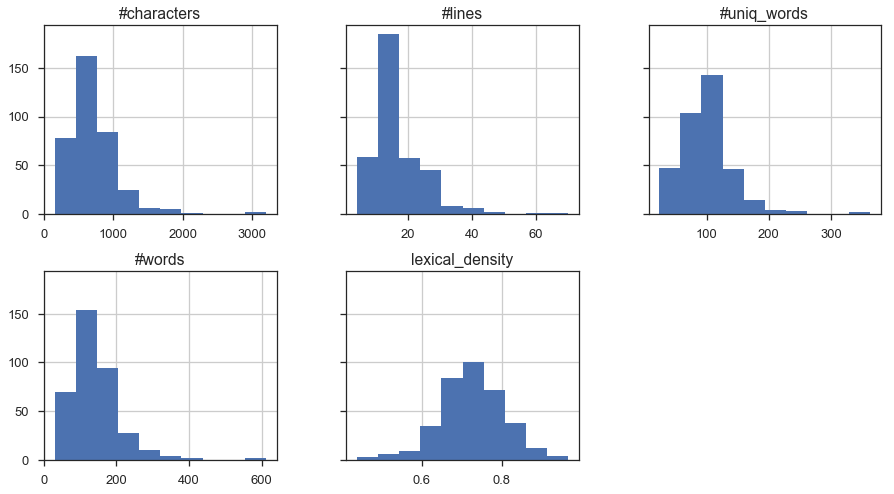

In [7]:
df.hist(sharey=True, layout=(2, 3), figsize=(15, 8));

Alternatively, look at violenplots for distributions.

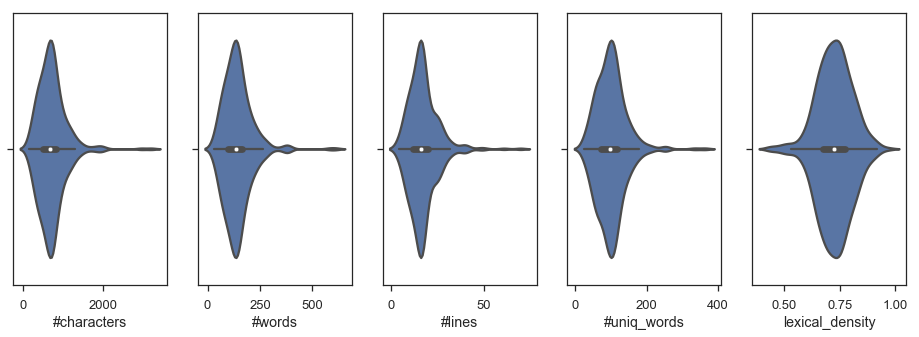

In [8]:
cols_metrics = df.select_dtypes(include=[np.number]).columns
fig, axs = plt.subplots(ncols=len(cols_metrics), figsize=(16, 5))
for i, c in enumerate(cols_metrics):
    sns.violinplot(x=df[c], ax=axs[i], sharex=True)

## 3.1 Word Length Distribution

Looking at the word lengths, median length is 4 letters. 
But there exists decent long tail of longer length words.

- Word lengths between 1-5 cover 85% of the total words used.

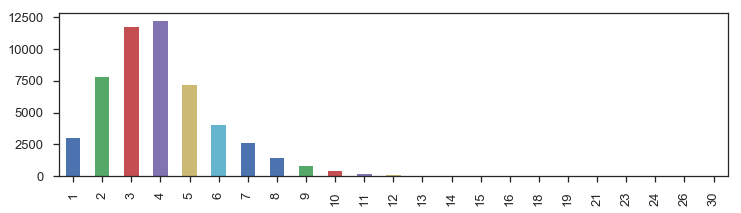

In [9]:
# Word length distribution
pd.Series(len(x) for x in ' '.join(df.lyrics).split()).value_counts().sort_index().plot(kind='bar', figsize=(12, 3))

Now, that gets us to move to look into words, phrases mostly used.

## 3.2 Most common words

Let's look at most commonly used words. We're not removing any stopwords.

- Single words may not give much insights -- `the, i you, my, me` are most common

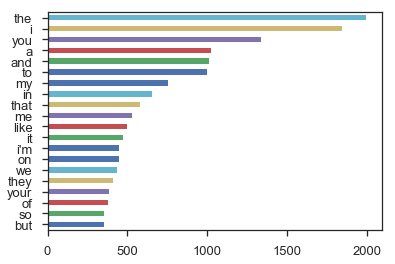

In [10]:
# top words
pd.Series(' '.join(df.lyrics).lower().split()).value_counts()[:20][::-1].plot(kind='barh')

## 3.3 Most common longer words

Among the longer words (length > 7), combination of (every|some|any)(body|thing|time) are most common.

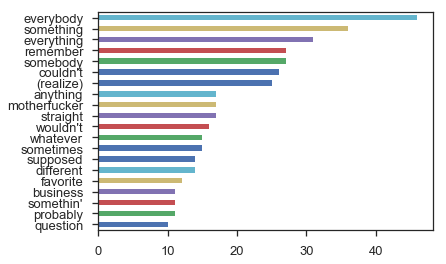

In [11]:
# top long words
pd.Series([w for w in ' '.join(df.lyrics).lower().split() if len(w) > 7]).value_counts()[:20][::-1].plot(kind='barh')

## 3.4 Most common n-grams

Let's first look at collocations, called n-grams, where we look are collated phrases.

In [12]:
from nltk import ngrams

In [13]:
def get_ngrams_from_series(series, n=2):
    # using nltk.ngrams
    lines = ' '.join(series).lower().split('\n')
    lgrams = [ngrams(l.split(), n) for l in lines]
    grams = [[' '.join(g) for g in list(lg)] for lg in lgrams]
    return [item for sublist in grams for item in sublist]

### 3.4.1 Most common bi-grams

- `in the` appears to most common bi-gram with 200+ occurrences and stand out from 2, 3rd popular ones

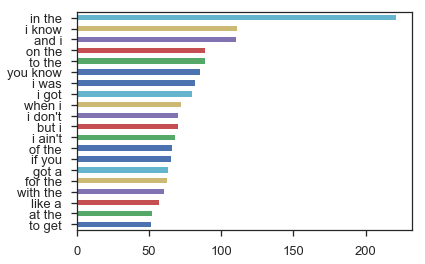

In [14]:
# Top bi-grams
pd.Series(get_ngrams_from_series(df.lyrics, 2)).value_counts()[:20][::-1].plot(kind='barh')

### 3.4.2 Most common tri-grams

- Many common trigrams start with `i` -- `i know that`, `i got a`, `i had to`, `i feel like`
- Expletives like `piss` make it to the top

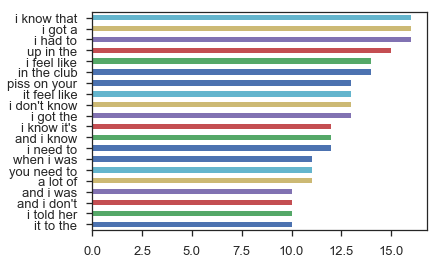

In [15]:
# Top tri-grams
pd.Series(get_ngrams_from_series(df.lyrics, 3)).value_counts()[:20][::-1].plot(kind='barh')

### 3.4.3 Most common quad-grams

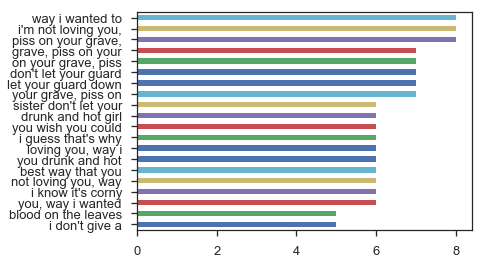

In [16]:
# Top four-grams
pd.Series(get_ngrams_from_series(df.lyrics, 4)).value_counts()[:20][::-1].plot(kind='barh')

# 4. Sentiment

Next, let's get sentiment scores of each song

In [17]:
# sentiment
import nltk
from nltk import sentiment
nltk.download('vader_lexicon')

d:\apps\anaconda2\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\pvardhan\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

Load the inbuilt vader Sentiment Analyzer

In [18]:
senti_analyze = sentiment.vader.SentimentIntensityAnalyzer()

Try it on first lyrics, it would return a dictionary with polarity scores, we'll use compound score only.

In [19]:
senti_analyze.polarity_scores(df.lyrics[0])

{'compound': -0.6658, 'neg': 0.153, 'neu': 0.71, 'pos': 0.137}

Apply on all lyrics and store the `['negative', 'neutral', 'positive']` segments as well.

In [20]:
df['sentiment_score'] = pd.DataFrame(df.lyrics.apply(senti_analyze.polarity_scores).tolist())['compound']
df['sentiment'] = pd.cut(df['sentiment_score'], [-np.inf, -0.35, 0.35, np.inf], labels=['negative', 'neutral', 'positive'])

Now, we have 1 text, 1 dimension, 6 metrics

In [21]:
df.head()

,lyrics,#characters,#words,#lines,#uniq_words,lexical_density,sentiment_score,sentiment
0,Let the suicide doors up\nI threw suicides on ...,675,131,16,99,0.755725,-0.6658,negative
1,"She said, ""'Ye, can we get married at the mall...",772,148,18,111,0.750000,-0.8690,negative
2,"Break records at Louis, ate breakfast at Gucci...",1479,286,33,212,0.741259,-0.9499,negative
3,What you doin' in the club on a Thursday?\nShe...,632,101,16,80,0.792079,-0.9900,negative
4,"I wanna fuck you hard on the sink\nAfter that,...",748,144,18,96,0.666667,-0.9869,negative


## 4.1 Sentiment Score distribution

Interestingly, West's songs have decent spread across the negative and positive sentiments.
Infact, most songs are either strongly positive or negative.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000F833320>]], dtype=object)

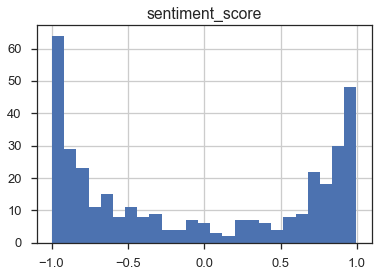

In [22]:
df[['sentiment_score']].hist(bins=25)

## 4.2 Correlation

Is there any Correlation between Sentiment Score and other metrics?

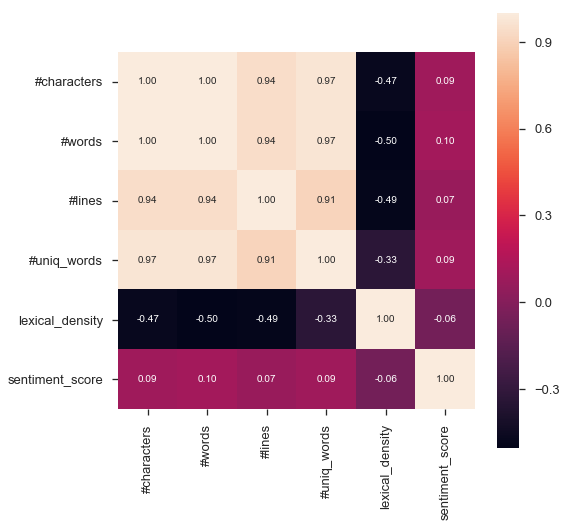

In [23]:
corr = df.corr()
plt.figure(figsize=(8, 8))
sns.heatmap(corr, annot=True, fmt='.2f', square=True,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

## 4.3 Pairwise relationships

Visualize pairwise combinations of continuous variables over `sentiment` category

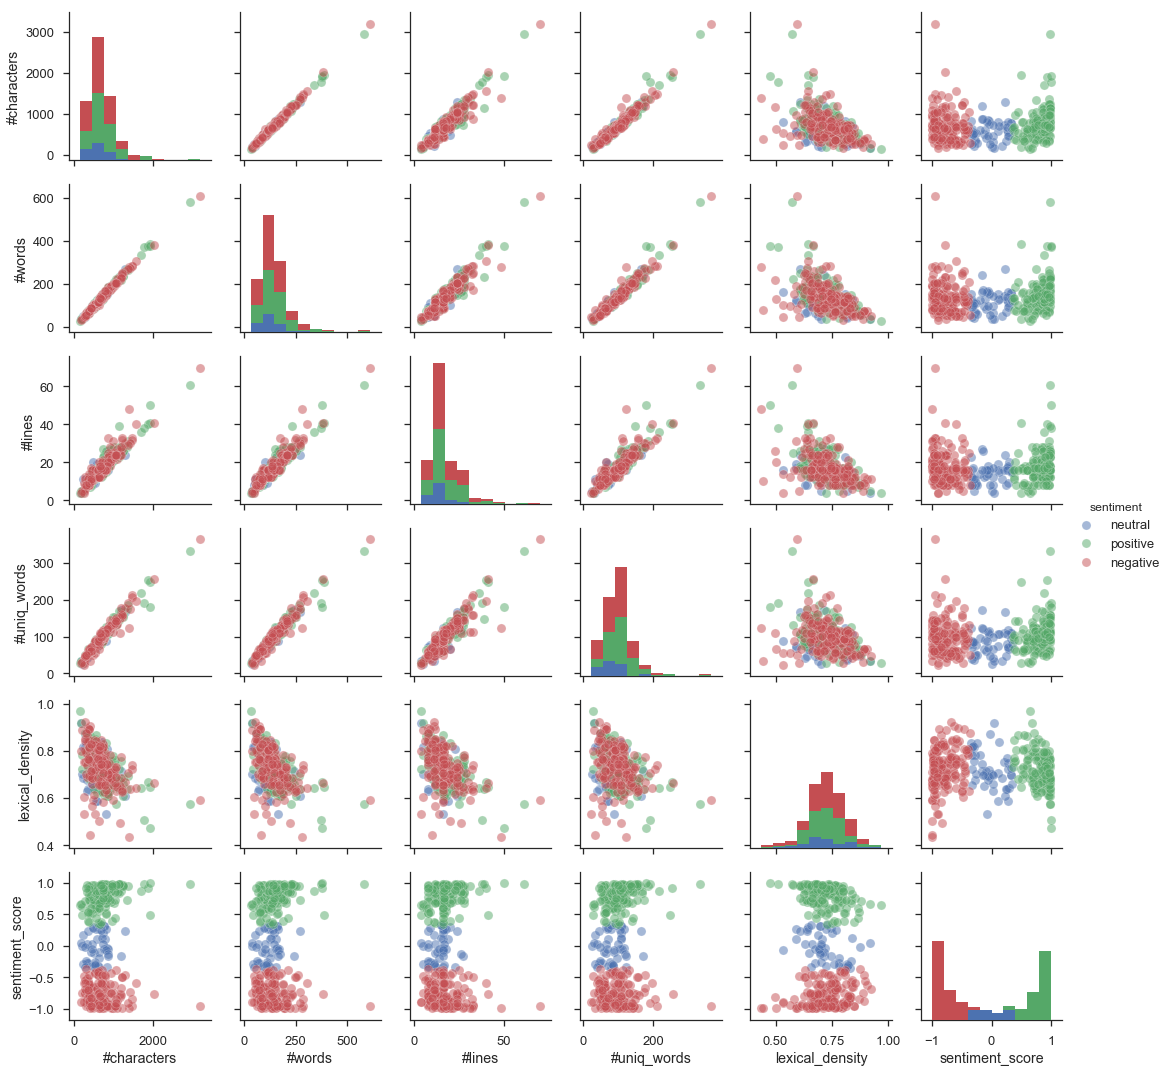

In [24]:
sns.pairplot(df, hue='sentiment', hue_order=['neutral', 'positive', 'negative'], 
             plot_kws={'alpha': 0.5})

## 4.4 Lexical density sentiments

Songs with lower lexical density tend to have strong sentiments (negative and positive)

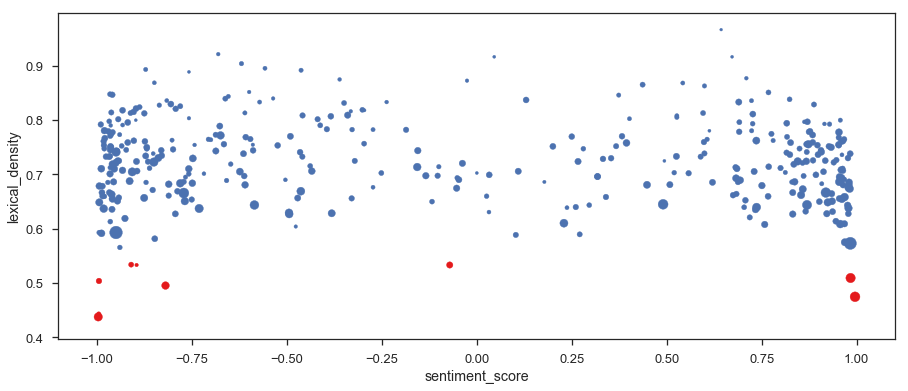

In [25]:
# Songs with lower lexical density tend to have strong sentiments
df.plot.scatter(x='sentiment_score', y='lexical_density', s=df['#characters']/20,
                c=np.where(df['lexical_density'].le(0.55), '#e41a1c', '#4c72b0'),
                figsize=(15, 6))

## 4.5 Non-parametric estimates

- Range of `unique words` is limited in `neutral` songs
- `Negative` songs tend to have higher lexical density but also larger spread
- `Negative` songs tend to lower `unique words` over `Positive` songs

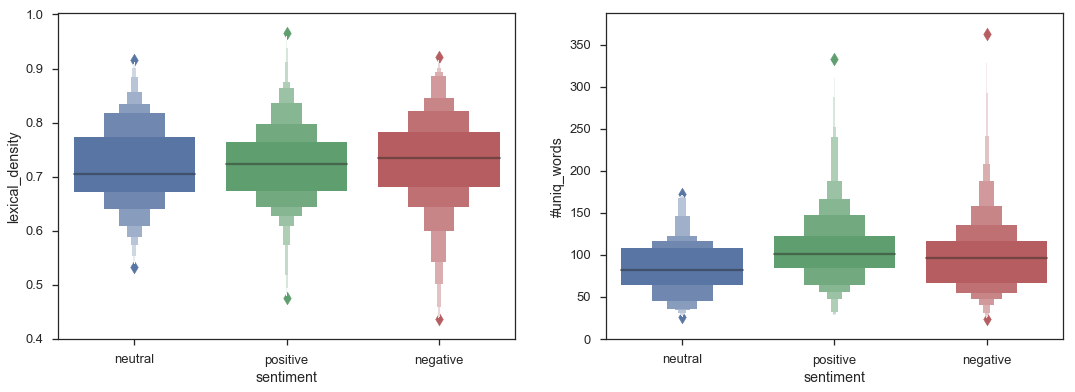

In [26]:
cols_metrics = ['lexical_density', '#uniq_words']
fig, axs = plt.subplots(figsize=(18, 6), ncols=len(cols_metrics))
for i, c in enumerate(cols_metrics):
    sns.lvplot(x='sentiment', y=c, data=df, ax=axs[i], order=['neutral', 'positive', 'negative'])

Looking at these same distributions with non-overlapping points.

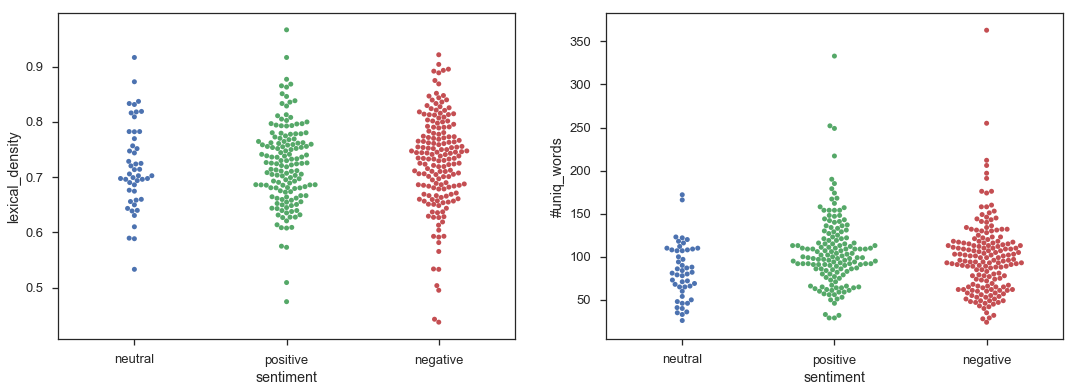

In [27]:
cols_metrics = ['lexical_density', '#uniq_words']
fig, axs = plt.subplots(figsize=(18, 6), ncols=len(cols_metrics))
for i, c in enumerate(cols_metrics):
    sns.swarmplot(x='sentiment', y=c, data=df, ax=axs[i], order=['neutral', 'positive', 'negative'])

# 5. Song Generator via Markov chain

We use a simplistic Markov chain model to generate song from a West's corpus

- The last two words are the current state.
- Next word depends on last two words only, or on present state only.
- The next word is randomly chosen from a statistical model of the corpus.

In [28]:
# Machine generated lyrics using Markov
import re
import random
from collections import defaultdict


class MarkovRachaita:
    def __init__(self, corpus='', order=2, length=8):
        self.order = order
        self.length = length
        self.words = re.findall("[a-z']+", corpus.lower())
        self.states = defaultdict(list)

        for i in range(len(self.words) - self.order):
            self.states[tuple(self.words[i:i + self.order])].append(self.words[i + order])

    def gen_sentence(self, length=8, startswith=None):
        terms = None
        if startswith:
            start_seed = [x for x in self.states.keys() if startswith in x]
            if start_seed:
                terms = list(start_seed[0])
        if terms is None:
            start_seed = random.randint(0, len(self.words) - self.order)
            terms = self.words[start_seed:start_seed + self.order]

        for _ in range(length):
            terms.append(random.choice(self.states[tuple(terms[-self.order:])]))

        return ' '.join(terms)

    def gen_song(self, lines=10, length=8, length_range=None, startswith=None):
        song = []
        if startswith:
            song.append(self.gen_sentence(length=length, startswith=startswith))
            lines -= 1
        for _ in range(lines):
            sent_len = random.randint(*length_range) if length_range else length
            song.append(self.gen_sentence(length=sent_len))
        return '\n'.join(song)

## 5.1 Generate Random Song

In [29]:
kanyai = MarkovRachaita(corpus=' '.join(df.lyrics))
print kanyai.gen_song(lines=10, length_range=[5, 10])

what if mary what if we die the money in
on this lonely night i came up y'all gave me
we know sometimes i gotta a duel
in the lobby niggas is bringing out
can i add that he do spaz out
to say hi i'm aria no you a hundred million and
the building ain't no scars a little blog just to get the
kate mimosa alessandra ambrosio anja rubik get olga
like the handyman but if you getting paper everybody
have to laugh so i guess i should've went to law school


## 5.2 Generate Song on Trump

In [30]:
print kanyai.gen_song(lines=10, length_range=[5, 10], startswith='trump')

donald trump taking dollars from y'all baby you're makin' it
fucking quit nigga just talked to farrakhan that's sensei nigga told
like it's still niggas that know me
spit a couple laps in my pajamas to
out the word can't 'round same time when nas said i
palm i take my life like theres no tomorrow wake up
know then errrr away i stuck my dick why fuckin' centerfolds
on a smpte but i prefer the term african american
when we cut i'm razorbladin' i'm so lazer
be your damn liar let's start the scrimmage


# 6. Topic Modelling

We'll create a simplistic topic model using Non-Negative Matrix Factorization (NMF) to group lyrics into topics.
LDA is another quite popular alternative for topic modelling.
We generate a tf-idf transformer, to apply it to the bag of words matrix that NMF will process with the TfidfVectorizer.

In [31]:
# Song themes via Simplistic topic modelling

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

no_topics = 5
no_features = 50
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(df.lyrics)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

def get_topics(model, feature_names, no_topwords):
    for topic_id, topic in enumerate(model.components_):
        print 'topic %d:' % (topic_id)
        print ' '.join([feature_names[i] for i in topic.argsort()[:-no_topwords-1:-1]])

s = pd.DataFrame(nmf.transform(tfidf)).idxmax(1)

List the derived topics, each represented as a list of top terms

In [32]:
# NMP topics
get_topics(nmf, tfidf_feature_names, 20)

topic 0:
know got don girl love fuck let ll baby said gotta tell bout ain shit mean want need told new
topic 1:
im niggas said bitch make good god got fuck just love bad cause shit ass need yeah new gon way
topic 2:
like black told said ll gon make hit em people feel ass girl ain got niggas love shit mean god
topic 3:
right life yeah let time look did cause good got man money need tell say feel know shit god make
topic 4:
just nigga ain man say niggas people make cause feel shit em want don way money did need time god


## 6.1 Top n-grams from topics

Now, let's get top tri-grams for each of these topics/themes

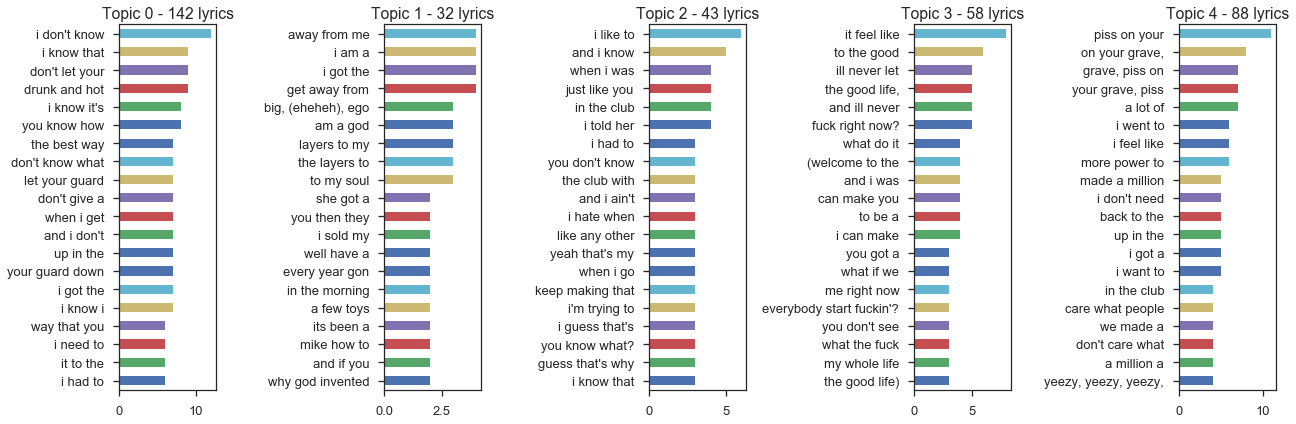

In [33]:
# Top n-grams from the topics
topics = set(s)
fig, axs = plt.subplots(figsize=(18, 6), ncols=len(topics))
for i, v in enumerate(topics):
    dfsm = df.loc[s.eq(v), 'lyrics']
    ngram = pd.Series(get_ngrams_from_series(dfsm, 3)).value_counts()[:20][::-1]
    ngram.plot(kind='barh', ax=axs[i], title='Topic {} - {} lyrics'.format(v, s.eq(v).sum()))
plt.tight_layout()
df['topic'] = s.astype(str).radd('Topic ')

In [34]:
df.head()

,lyrics,#characters,#words,#lines,#uniq_words,lexical_density,sentiment_score,sentiment,topic
0,Let the suicide doors up\nI threw suicides on ...,675,131,16,99,0.755725,-0.6658,negative,Topic 0
1,"She said, ""'Ye, can we get married at the mall...",772,148,18,111,0.750000,-0.8690,negative,Topic 1
2,"Break records at Louis, ate breakfast at Gucci...",1479,286,33,212,0.741259,-0.9499,negative,Topic 3
3,What you doin' in the club on a Thursday?\nShe...,632,101,16,80,0.792079,-0.9900,negative,Topic 0
4,"I wanna fuck you hard on the sink\nAfter that,...",748,144,18,96,0.666667,-0.9869,negative,Topic 0


## 6.2 Sentiment across Topics

- Topic 0 has songs mostly concentrated for high polar sentiments
- Topic 1 songs which are positive have a high score
- Topic 2 doesn't have neutral songs

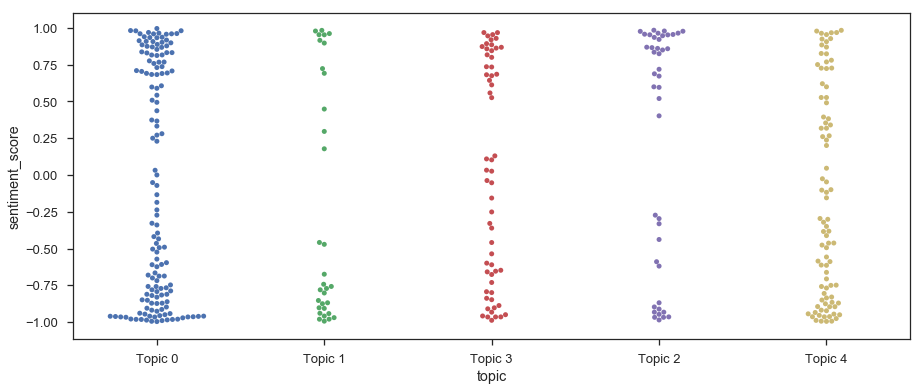

In [35]:
fig, axs = plt.subplots(figsize=(15, 6))
sns.swarmplot(x='topic', y='sentiment_score', data=df)

## 6.3 Lexical Density across Topics

- Lexical density is mostly concentrated around 0.7 higher for Topic 0
- Lexical density is higher for Topic 1

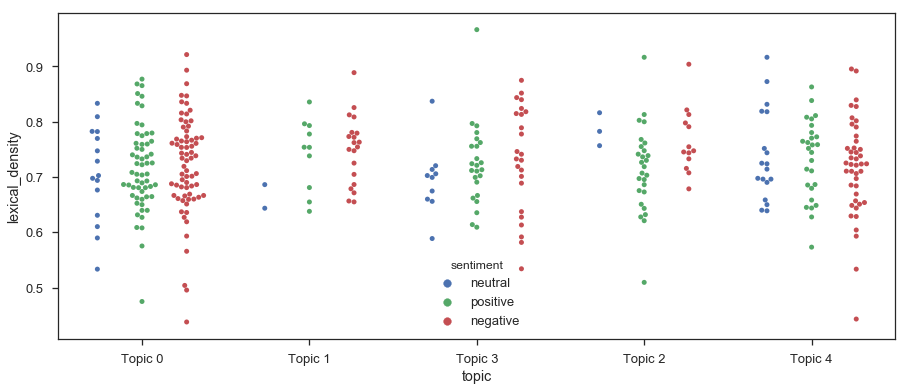

In [36]:
fig, axs = plt.subplots(figsize=(15, 6))
sns.swarmplot(x='topic', y='lexical_density', hue='sentiment',
              hue_order=['neutral', 'positive', 'negative'], data=df, dodge=True)

# 7. Next Steps

With that we've covered what we began with. Kanye's corpus has good variations with mix of lexical sentiments. 

- We could improve on theme based Kanye's machine generated songs
- Topic modelling can made easier to interpret the themes
- Detect Names, Brands, Emotions mentioned in songs
- Add external data (date, genre, audio, visual, billboard reception, youtube views etc)